# System Info

In [1]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = "/home/user/.vscode-server-insiders/bin/d487078dc7fc1c276657cadb61b4f63833a8df55/bin/code-insiders"
  JULIA_GPG = 3673DF529D9049477F76B37566E3C7DC03D6E495
  JULIA_PATH = /usr/local/julia
  JULIA_NUM_THREADS = 3
  JULIA_VERSION = 1.4.1


# Setup

In [2]:
cd("../")

In [3]:
ENV["COLUMNS"] = 1000
ENV["LINES"] = 1000
;

# Packages

In [4]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1952737267621174045\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14650679594040015923\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1952737267621174045\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [5]:
using Gadfly, DataFrames, Statistics, StatsBase, Distributions, LinearAlgebra

In [6]:
using Query

In [7]:
using Gen

In [8]:
include("../src/Utils.jl")
using .Utils

# Data

In [9]:
sppnames = ["afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens"]
brainvolcc = [438 , 452 , 612, 521, 752, 871, 1350]
brainvolcc = brainvolcc / maximum(brainvolcc)

masskg = [37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]
masskg = standardize(ZScoreTransform, masskg, dims=1)

df = DataFrame([sppnames, brainvolcc, masskg], [:species, :brain, :mass])
first(df, 5)

5×3 DataFrame
│ Row │ species     │ brain    │ mass      │
│     │ String      │ Float64  │ Float64   │
├─────┼─────────────┼──────────┼───────────┤
│ 1   │ afarensis   │ 0.324444 │ -0.779467 │
│ 2   │ africanus   │ 0.334815 │ -0.91702  │
│ 3   │ habilis     │ 0.453333 │ -1.00872  │
│ 4   │ boisei      │ 0.385926 │ -0.366808 │
│ 5   │ rudolfensis │ 0.557037 │ 0.91702   │

# Model

In [10]:
X = df[:, [:mass]] |> Matrix
Y = df[:, :brain];

In [11]:
@gen function model_1(X::Matrix{Float64})
    # define the priors
    α = @trace(normal(0.5, 1), :α)
    β = @trace(normal(0, 10), :β)
    log_σ = @trace(normal(0, 1), :log_σ)
    
    
    # model the ys
    for (i, (mass,)) in enumerate(eachrow(X))
        μ = α + β * mass
        @trace(normal(μ, exp(log_σ)), (:y, i))
    end
end;


In [12]:
N = 10
budget = 10
params = [:α, :β, :log_σ]

results = @time get_posterior_samples(model_1, N, budget, X, Y, params);

  3.177366 seconds (2.78 M allocations: 139.762 MiB, 2.38% gc time)


In [13]:
report = summarize_posterior_samples(results, params)

num_columns = setdiff(names(report), [:param])
for num_column in num_columns
    report[:, num_column] = round.(report[:, num_column], digits=2)
end

report

┌ Warning: RCall.jl: Loading required package: rethinking
│ Loading required package: rstan
│ Loading required package: StanHeaders
│ Loading required package: ggplot2
│ rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)
│ For execution on a local, multicore CPU with excess RAM we recommend calling
│ options(mc.cores = parallel::detectCores()).
│ To avoid recompilation of unchanged Stan programs, we recommend calling
│ rstan_options(auto_write = TRUE)
│ Loading required package: parallel
│ Loading required package: dagitty
│ rethinking (Version 2.01)
│ 
│ Attaching package: ‘rethinking’
│ 
│ The following object is masked from ‘package:stats’:
│ 
│     rstudent
│ 
└ @ RCall /home/user/.julia/packages/RCall/jOnwc/src/io.jl:160


3×5 DataFrame
│ Row │ param │ mean  │ std  │ 5%    │ 95%  │
│     │ Any   │ Any   │ Any  │ Any   │ Any  │
├─────┼───────┼───────┼──────┼───────┼──────┤
│ 1   │ α     │ 0.62  │ 0.65 │ -0.42 │ 1.36 │
│ 2   │ β     │ -0.48 │ 1.51 │ -2.5  │ 1.55 │
│ 3   │ log_σ │ 0.63  │ 0.67 │ -0.39 │ 1.31 │

# Log Pointwise Predictive Density (LPPD)

## Calculating LPPD

In [14]:
function observation_log_probabilities(params::DataFrameRow, choices, X, model)
   
    # assume the Y address is (:y, i) where i is the i-th observation    
    N = filter(k -> k isa Tuple && k[1] == :y, keys(choices.leaf_nodes)) |> length
    
    for (k,v) in zip(keys(params), values(params))
        choices[k] = v
    end
    trace, _ = generate(model, (X, ), choices)
    
    [project(trace, Gen.select((:y, i))) for i in 1:N]

end
;

In [15]:
function get_prediction_log_probs(posterior_params::DataFrame, X::AbstractArray, Y::Vector, model)
    choices = Gen.choicemap()
    
    # Y is a constant regardless of choice of parameters
    for (i, y) in enumerate(Y)
        choices[(:y, i)] = y
    end
    
    # S x N, where S number of parameter samples, N number of observations
    map(eachrow(posterior_params)) do params
        observation_log_probabilities(params, choices, X, model)
    end |>
    m -> hcat(m...)'
    
end
;    

In [16]:
function lppd(observed_log_scores::AbstractArray)
    
    # observed_log_scores is S x N where S is number of parameter samples and
    # N is number of observations
    S, _ = size(observed_log_scores)
    
    # 1 x N
    map(eachcol(observed_log_scores)) do log_probs
        (log_probs .|> exp |> sum |> log) - log(S)
    end
end
;

In [17]:
lprob = get_prediction_log_probs(DataFrame(results, params), X, Y, model_1)
round.(lppd(lprob), digits=2)

7-element Array{Float64,1}:
 -1.99
 -2.09
 -2.11
 -1.69
 -1.9
 -2.02
 -1.6

## Intution behind LPPD

In [18]:
@manipulate for α = [6.25, 50, 5000], θ = [0.4, 0.1, 0.001]
    y = 10 # target value for observation i
    x = 2  # feature value for observation i
    
    posterior_dist = Gamma(α, θ) 
    sample_βs = rand(posterior_dist, 10_0000)
    
    p1 = plot(x=sample_βs, Geom.density, Coord.Cartesian(xmin=-1, xmax=10, ymax=0.8),
              Guide.xlabel("β"), Guide.ylabel("density"),
              Guide.title("Posterior distribution of β"))
    
    S = 100
    sample_βs = rand(sample_βs, S)
    # distribution of y for each β
    pred_ys_dists = Normal.(sample_βs .* x, 0.2)
   
    predictions = [layer(x=rand(pred_ys_dist, 1000),  Geom.polygon(fill=true, preserve_order=true), Stat.density) 
                   for pred_ys_dist in pred_ys_dists]

    target = layer(xintercept = [10], Gadfly.Geom.vline(color="red"))

    p2 = plot(target, predictions..., Theme(alphas=[0.3]),
              Guide.xlabel("yᵢ"), Guide.ylabel("density"),
              Guide.title("Predicted yᵢ (blue) vs Target yᵢ (red)"),
              Coord.Cartesian(xmin=0, xmax=15))
    
    lppd_score = (Distributions.logpdf.(pred_ys_dists, y) .|> exp |> sum |> log) - log(S)
    lppd_score = round(lppd_score, digits=4)
    
    vbox(hbox(SVGJS(13.8Gadfly.cm, 2Gadfly.mm), md"lppd: $lppd_score"),
         hbox(p1, p2),
         md"IQR: $(round(iqr(sample_βs), digits=2))"
       )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["α"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 3,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
2, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/user/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/user/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/user/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/home/user/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/home/user/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f35f1de0eb0, Task (runnable) @0x00007f35f1de0eb0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"6.25\",\"50.0\",\"5000.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"506321508584492893\",\"id\":\"ob_03\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"506321508584492893\",\"id\":\"ob_02\",\"type\":\"obser

In [19]:
@manipulate for μ = [2, 5], σ = [1e-12, 1e-2]
    y = 10 # target value for observation i
    x = 2  # feature value for observation i
    
    posterior_dist = Normal(μ, σ) 
    sample_βs = rand(posterior_dist, 10_0000)
    
    p1 = plot(x=sample_βs, Geom.density,
              Guide.xlabel("β"), Guide.ylabel("density"),
              Guide.title("Posterior distribution of β"))
    
    S = 100
    sample_βs = rand(sample_βs, S)
    # distribution of y for each β
    pred_ys_dists = Normal.(sample_βs .* x, 0.2)
   
    predictions = [layer(x=rand(pred_ys_dist, 1000),  Geom.polygon(fill=true, preserve_order=true), Stat.density) 
                   for pred_ys_dist in pred_ys_dists]

    target = layer(xintercept = [10], Gadfly.Geom.vline(color="red"))

    p2 = plot(target, predictions..., Theme(alphas=[0.3]),
              Guide.xlabel("yᵢ"), Guide.ylabel("density"),
              Guide.title("Predicted yᵢ (blue) vs Target yᵢ (red)"),
              Coord.Cartesian(xmin=0, xmax=15))
    
    lppd_score = (Distributions.logpdf.(pred_ys_dists, y) .|> exp |> sum |> log) - log(S)
    lppd_score = round(lppd_score, digits=4)
    
    vbox(hbox(SVGJS(13.8Gadfly.cm, 2Gadfly.mm), md"lppd: $lppd_score"),
         hbox(p1, p2),
         md"IQR: $(round(iqr(sample_βs), digits=2))"
       )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["μ"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 2,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/user/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/user/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/user/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/home/user/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/home/user/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f35f656e4a0, Task (runnable) @0x00007f35f656e4a0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"2\",\"5\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"13069478424952534993\",\"id\":\"ob_15\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"13069478424952534993\",\"id\":\"ob_14\",\"type\":\"observable\"})};\n

# WAIC

## WAIC Calculation

In [20]:
function pwaic(observed_log_scores::AbstractArray)
    
    # observed_log_scores is S x N where S is number of parameter samples and
    # N is number of observations
    
    # 1 x N
    map(eachcol(observed_log_scores)) do log_probs
        var(log_probs)
    end
end
;

In [21]:
waic(observed_log_scores::AbstractArray) = lppd(observed_log_scores) - pwaic(observed_log_scores)

waic (generic function with 1 method)

# Featured Image

In [22]:
using DataFrames, GLM

Build the training set:

In [23]:
# number of observations in training and test set
N = 20
ϵ = 5

# the relationship between X and Y
f(x) = 2 * x + 5

# generate some x
xs = rand(Uniform(0, 10), N)

# compute y and add some noise
ys = rand.(Normal.(f.(xs), ϵ))

train = DataFrame(x = xs, y = ys)
;

Build the test set:

In [24]:
# generate some x
xs = rand(Uniform(5, 15), N)

# compute y and add some noise
ys = rand.(Normal.(f.(xs), ϵ))

test = DataFrame(x = xs, y = ys)
;

Plot the training set and test set:

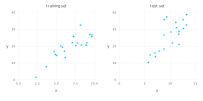

In [25]:
set_default_plot_size(8Gadfly.inch, 4Gadfly.inch)

p1 = plot(train, x = :x, y = :y, Geom.point, Guide.title("training set"))
p2 = plot(test, x = :x, y = :y, Geom.point, Guide.title("test set"))

hstack(p1, p2)

Build the model:

In [26]:
model1 = lm(@formula(y ~ x), train)
model2 = lm(@formula(y ~ x^5 + x^4 + x ^ 3 + x ^ 2 + x), train)

@show r2(model1)
@show r2(model2)

print(model1)
print(model2)
;

r2(model1) = 0.7247833622641137
r2(model2) = 0.7884683034198708
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  0.106889    2.94805   0.0362576    0.9715   -6.08674    6.30052
x            2.84746     0.413576  6.88499      <1e-5     1.97857    3.71635
────────────────────────────────────────────────────────────────────────────StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + :(x ^ 5) + :(x ^ 4) + :(x ^ 3) + :(x ^ 2) + x

Coefficients:
─────────────────────────────────────────────────────────────────────

Using the linear models:

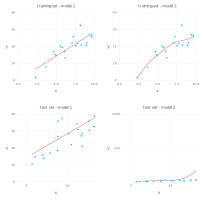

In [27]:
set_default_plot_size(8Gadfly.inch, 8Gadfly.inch)

p_train = layer(train, x = :x, y = :y, Geom.point)
p_test = layer(test, x = :x, y = :y, Geom.point)


p_model1_train =  layer(x = train.x, 
                        y = predict(model1, train), 
                        Geom.line, Theme(default_color="red"))

p_model1_test =  layer(x = test.x,
                       y = predict(model1, test), 
                       Geom.line, Theme(default_color="red"))


p_model2_train =  layer(x = train.x, 
                        y = predict(model2, train), 
                        Geom.line, Theme(default_color="red"))

p_model2_test =  layer(x = test.x, 
                       y = predict(model2, test), 
                       Geom.line, Theme(default_color="red"))


p1 = hstack(plot(p_train, p_model1_train, Guide.title("training set - model 1")),
            plot(p_train, p_model2_train, Guide.title("training set - model 2")))

p2 = hstack(plot(p_test, p_model1_test, Guide.title("test set - model 1"), Coord.Cartesian(xmin=4)),
            plot(p_test, p_model2_test, Guide.title("test set - model 2"), Coord.Cartesian(xmin=4, ymax=1e3)))

vstack(p1, p2)

# Estimate Overfit

Build the dataset:

In [28]:
N = 20
num_feats = 4

function build_dataset(obs, feats)
    columns = vcat(:y, [Symbol("x"*string(i)) for i in 1:feats])
    
    Σ = rand(Normal(0, 1), (feats, feats)) |> 
        Symmetric |>
        m -> begin 
                m[diagind(m)] .= 1
                m
             end
    
    μ = rand(Normal(0, 1), feats)

    X = rand(MvNormal(μ, Σ * Σ'), obs)'

    Y = 0.15 .* X[:, 1] - 0.4 .* X[:, 2]
    Y = rand.(Normal.(Y, 0.5))
    
    DataFrame(hcat(Y, X), columns)
end

train_set = build_dataset(N, num_feats)
test_set = build_dataset(N, num_feats)

first(train_set, 5)

5×5 DataFrame
│ Row │ y          │ x1       │ x2         │ x3         │ x4       │
│     │ Float64    │ Float64  │ Float64    │ Float64    │ Float64  │
├─────┼────────────┼──────────┼────────────┼────────────┼──────────┤
│ 1   │ 0.53921    │ 2.09684  │ -0.0661104 │ 0.00928664 │ 0.718647 │
│ 2   │ 0.407245   │ 3.79365  │ -0.674654  │ -0.043497  │ 2.36889  │
│ 3   │ 0.742945   │ 2.81079  │ -0.602014  │ 0.31892    │ 1.80365  │
│ 4   │ -2.42806   │ -1.09097 │ 3.6947     │ 3.67886    │ 1.12491  │
│ 5   │ -0.0825215 │ 2.0693   │ 0.428869   │ 0.30942    │ 0.77154  │

Build some linear models:

In [29]:
model1 = lm(@formula(y ~ x1 + x2 + 0), train_set)

@show r2(model1)
model1

r2(model1) = 0.8662805497713596


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 0 + x1 + x2

Coefficients:
────────────────────────────────────────────────────────────────────
     Estimate  Std. Error   t value  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────
x1   0.139559   0.0493374   2.82865    0.0111   0.0359044   0.243213
x2  -0.478958   0.054688   -8.758      <1e-7   -0.593853   -0.364062
────────────────────────────────────────────────────────────────────

In [30]:
model2 = lm(@formula(y ~ x1 + x2 + x3 + x4 + 0), train_set) 


@show r2(model2)
model2

r2(model2) = 0.9015010308982727


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 0 + x1 + x2 + x3 + x4

Coefficients:
───────────────────────────────────────────────────────────────────────
      Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────
x1   0.0633066    0.108125   0.585496    0.5664  -0.165908   0.292521
x2  -0.254589     0.106922  -2.38108     0.0300  -0.481253  -0.0279253
x3  -0.323611     0.15536   -2.08298     0.0537  -0.652959   0.00573692
x4   0.141489     0.199217   0.710224    0.4878  -0.280832   0.563809
───────────────────────────────────────────────────────────────────────

Evaluate using RMSE:

In [31]:
rmse(ŷ, y) = sum((y - ŷ).^2)/length(y) |> sqrt

model1_insample = rmse(predict(model1, train_set), train_set.y)
model1_outsample = rmse(predict(model1, test_set), test_set.y)

model2_insample = rmse(predict(model2, train_set), train_set.y)
model2_outsample = rmse(predict(model2, test_set), test_set.y)

@show model1_insample
@show model1_outsample

@show model2_insample
@show model2_outsample
;

model1_insample = 0.4838868781903642
model1_outsample = 0.4002490989933415
model2_insample = 0.4153004452019242
model2_outsample = 0.8339001822274984


Build Gen models:

In [32]:
params_model_1 = [:Β₁, :Β₂]
params_model_2 = [:Β₁, :Β₂, :Β₃, :Β₄]

X_model_1 = train_set[:, [:x1, :x2]] |> Matrix
X_model_2 = train_set[:, [:x1, :x2, :x3, :x4]] |> Matrix
Y = train_set.y

@gen function model_1(X::Matrix{Float64})
    # define the priors
    Β₁ = @trace(normal(0, 5), :Β₁)
    Β₂ = @trace(normal(0, 5), :Β₂)    
    
    # model the ys
    for (i, (x1, x2)) in enumerate(eachrow(X))
        μ = Β₁ * x1 + Β₂ * x2
        @trace(normal(μ, 1), (:y, i))
    end
end

@gen function model_2(X::Matrix{Float64})
    # define the priors
    Β₁ = @trace(normal(0, 5), :Β₁)
    Β₂ = @trace(normal(0, 5), :Β₂)
    Β₃ = @trace(normal(0, 5), :Β₃)
    Β₄ = @trace(normal(0, 5), :Β₄)
    
    # model the ys
    for (i, (x1, x2, x3, x4)) in enumerate(eachrow(X))
        μ =  Β₁ * x1 + Β₂ * x2 +  Β₃ * x3 + Β₄ * x4
        @trace(normal(μ, 1), (:y, i))
    end
end
;

Sample some parameters from the posterior:

In [33]:
N = 1000
budget = 1000

model_1_results = @time get_posterior_samples(model_1, N, budget, X_model_1, Y, params_model_1)
model_1_summary = summarize_posterior_samples(model_1_results, params_model_1)

 61.895864 seconds (185.43 M allocations: 8.784 GiB, 16.84% gc time)


2×5 DataFrame
│ Row │ param │ mean      │ std      │ 5%        │ 95%       │
│     │ Any   │ Any       │ Any      │ Any       │ Any       │
├─────┼───────┼───────────┼──────────┼───────────┼───────────┤
│ 1   │ Β₁    │ 0.137527  │ 0.162167 │ -0.119225 │ 0.390048  │
│ 2   │ Β₂    │ -0.473956 │ 0.180146 │ -0.761426 │ -0.190288 │

In [34]:
N = 1000
budget = 8000


model_2_results =  @time get_posterior_samples(model_2, N, budget, X_model_2, Y, params_model_2)
model_2_summary = summarize_posterior_samples(model_2_results, params_model_2)

786.116134 seconds (1.73 G allocations: 79.054 GiB, 16.92% gc time)


4×5 DataFrame
│ Row │ param │ mean      │ std      │ 5%        │ 95%      │
│     │ Any   │ Any       │ Any      │ Any       │ Any      │
├─────┼───────┼───────────┼──────────┼───────────┼──────────┤
│ 1   │ Β₁    │ 0.0511043 │ 0.557159 │ -0.826851 │ 0.939929 │
│ 2   │ Β₂    │ -0.243597 │ 0.547038 │ -1.10079  │ 0.632927 │
│ 3   │ Β₃    │ -0.332134 │ 0.7866   │ -1.59272  │ 0.891401 │
│ 4   │ Β₄    │ 0.190663  │ 1.03793  │ -1.47128  │ 1.85565  │

Evaluate the LPPD for each model:

In [35]:
lppd_model1_insample = get_prediction_log_probs(DataFrame(model_1_results, params_model_1), X_model_1, Y, model_1) |> 
    lppd |> 
    sum


lppd_model2_insample = get_prediction_log_probs(DataFrame(model_2_results, params_model_2), X_model_2, Y, model_2) |> 
    lppd |> 
    sum

lppd_model1_outsample = get_prediction_log_probs(DataFrame(model_1_results, params_model_1), 
                                                 test_set[:, [:x1, :x2]] |> Matrix, 
                                                 test_set.y, model_1) |> 
    lppd |> 
    sum

lppd_model2_outsample = get_prediction_log_probs(DataFrame(model_2_results, params_model_2), 
                                                test_set[:, [:x1, :x2, :x3, :x4]] |> Matrix, 
                                                test_set.y, model_2) |> 
    lppd |> 
    sum


@show lppd_model1_insample
@show lppd_model1_outsample

@show lppd_model2_insample
@show lppd_model2_outsample
;

lppd_model1_insample = -22.772329588104196
lppd_model1_outsample = -23.883259949390624
lppd_model2_insample = -26.834629373295463
lppd_model2_outsample = -46.656570342839636


The pwaic of model 1 and model 2:

In [36]:
get_prediction_log_probs(DataFrame(model_1_results, params_model_1), X_model_1, Y, model_1) |>
    pwaic |>
    sum

2.1406916675481167

In [37]:
get_prediction_log_probs(DataFrame(model_2_results, params_model_2), X_model_2, Y, model_2) |>
    pwaic |>
    sum

17.34986022727213

The waic of model 1 and model 2:

In [38]:
get_prediction_log_probs(DataFrame(model_1_results, params_model_1), X_model_1, Y, model_1) |>
   waic |>
   sum

-24.913021255652314

In [39]:
get_prediction_log_probs(DataFrame(model_2_results, params_model_2), X_model_2, Y, model_2) |>
    waic |>
    sum

-44.184489600567595

# WAIC penalty analysis

In [40]:
logprobs_model_1 = get_prediction_log_probs(DataFrame(model_1_results, params_model_1), X_model_1, Y, model_1)
logprobs_model_2 = get_prediction_log_probs(DataFrame(model_2_results, params_model_2), X_model_2, Y, model_2)
;

In [41]:
data = [logprobs_model_1 |> lppd,
        logprobs_model_2 |> lppd,
        logprobs_model_1 |> pwaic,
        logprobs_model_2 |> pwaic]

obs_analysis = DataFrame(data, [:lppd_m1, :lppd_m2, :pwaic_m1, :pwaic_m2])
round.(obs_analysis, digits=4)

20×4 DataFrame
│ Row │ lppd_m1 │ lppd_m2 │ pwaic_m1 │ pwaic_m2 │
│     │ Float64 │ Float64 │ Float64  │ Float64  │
├─────┼─────────┼─────────┼──────────┼──────────┤
│ 1   │ -0.9936 │ -1.0976 │ 0.0128   │ 0.0834   │
│ 2   │ -1.1353 │ -1.3174 │ 0.1191   │ 0.5241   │
│ 3   │ -1.0049 │ -1.1876 │ 0.0181   │ 0.1611   │
│ 4   │ -1.1826 │ -1.3368 │ 0.1846   │ 0.6157   │
│ 5   │ -0.9954 │ -1.0969 │ 0.0129   │ 0.0721   │
│ 6   │ -1.2323 │ -1.5145 │ 0.005    │ 1.6568   │
│ 7   │ -1.1318 │ -1.404  │ 0.1228   │ 1.0021   │
│ 8   │ -1.3422 │ -1.5375 │ 0.3297   │ 1.3141   │
│ 9   │ -1.1144 │ -1.4218 │ 0.1116   │ 1.0255   │
│ 10  │ -1.0908 │ -1.6642 │ 0.089    │ 4.7086   │
│ 11  │ -1.0743 │ -1.3114 │ 0.0682   │ 0.4775   │
│ 12  │ -1.3614 │ -1.3007 │ 0.0607   │ 0.567    │
│ 13  │ -0.9764 │ -1.1475 │ 0.0073   │ 0.1277   │
│ 14  │ -1.1041 │ -1.4051 │ 0.1056   │ 0.7963   │
│ 15  │ -1.1185 │ -1.3721 │ 0.1175   │ 0.7318   │
│ 16  │ -1.1145 │ -1.4261 │ 0.1221   │ 0.9033   │
│ 17  │ -1.1183 │ -1.3243 │ 0.1092   │ 0.6276   │
│ 18  │ -1.0841 │ -1.1405 │ 0.0398   │ 0.1253   │
│ 19  │ -1.4753 │ -1.4269 │ 0.3821   │ 1.0557   │
│ 20  │ -1.1221 │ -1.4015 │ 0.1225   │ 0.7742   │

In [42]:
df1 = DataFrame(logprobs_model_1 .|> exp, [Symbol(string(i)) for i in 1:20])
df1[!, :model] .= "1"

df2 = DataFrame(logprobs_model_2 .|> exp, [Symbol(string(i)) for i in 1:20])
df2[!, :model] .= "2"

df = vcat(df1, df2)
df = stack(df, 1:20)
rename!(df, [:observation, :density, :model])

first(df, 5)

5×3 DataFrame
│ Row │ observation │ density  │ model  │
│     │ Symbol      │ Float64  │ String │
├─────┼─────────────┼──────────┼────────┤
│ 1   │ 1           │ 0.398236 │ 1      │
│ 2   │ 1           │ 0.331352 │ 1      │
│ 3   │ 1           │ 0.397432 │ 1      │
│ 4   │ 1           │ 0.398171 │ 1      │
│ 5   │ 1           │ 0.355716 │ 1      │

In [43]:
gdf = groupby(df, [:observation, :model])

f(xs) = begin
    markers =  [0.0, 0.25, 0.5, 0.75, 1.0]
    vals = quantile(xs, markers)
    (;zip(Symbol.(markers), vals)..., mean=mean(xs), var=var(xs))
end
    
dist = combine(:density => f, gdf)
first(dist, 6)

6×9 DataFrame
│ Row │ observation │ model  │ 0.0        │ 0.25     │ 0.5      │ 0.75     │ 1.0      │ mean     │ var        │
│     │ Symbol      │ String │ Float64    │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │ Float64    │
├─────┼─────────────┼────────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────────────┤
│ 1   │ 1           │ 1      │ 0.128113   │ 0.356681 │ 0.383953 │ 0.396006 │ 0.398942 │ 0.370225 │ 0.00128753 │
│ 2   │ 1           │ 2      │ 0.0376915  │ 0.297114 │ 0.361895 │ 0.390443 │ 0.398942 │ 0.333666 │ 0.00525248 │
│ 3   │ 2           │ 1      │ 0.0183488  │ 0.278309 │ 0.348069 │ 0.386522 │ 0.398942 │ 0.321327 │ 0.00649617 │
│ 4   │ 2           │ 2      │ 0.00272117 │ 0.174993 │ 0.295724 │ 0.373521 │ 0.398942 │ 0.267821 │ 0.0133956  │
│ 5   │ 3           │ 1      │ 0.112535   │ 0.352784 │ 0.380873 │ 0.394761 │ 0.398942 │ 0.366092 │ 0.0016647  │
│ 6   │ 3           │ 2      │ 0.0288434  │ 0.246761 │ 0.331738 │ 0.382964 │ 0.398942 │ 0.304953 │ 0.00801818 │

In [44]:
set_default_plot_size(20Gadfly.cm, 20Gadfly.cm)

@manipulate for i = 1:4
    
    start_ob = 1 + (i - 1) * 5
    end_ob = 5 + (i - 1) * 5

    subset_df = df |>
    @filter(parse(Int, string(_.observation)) >= start_ob && parse(Int, string(_.observation)) <= end_ob) |>
    DataFrame

    plot(subset_df, 
            x = :observation, 
            ygroup = :model, 
            y = :density,
            Guide.title("Distribution of Pointwise Predictive Density"), 
            Geom.subplot_grid(Geom.boxplot, free_y_axis = true))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 4,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
2, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/user/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/user/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/user/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/home/user/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/home/user/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f35ed8a2710, Task (runnable) @0x00007f35ed8a2710), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"10631558721967901462\",\"id\":\"ob_26\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"10631558721967901462\",\"id\":\"ob_25\",\"type\":\"obse

# Simulate

This takes too long...

In [45]:
struct ModelParams
    model_fn
    params::Vector{Symbol}
    features::Vector{Symbol}
    posterior_samples::Int
    budget::Int
end

In [46]:
function simulate_train_test_set(num_obs::Int, num_feats::Int, model::ModelParams)
    train_set = build_dataset(num_obs, num_feats)
    test_set = build_dataset(num_obs, num_feats)
    
    train_X = train_set[:, model.features] |> Matrix
    train_Y = train_set.y
    
    test_X = test_set[:, model.features] |> Matrix
    test_Y = test_set.y
    
    
    model_results = get_posterior_samples(model.model_fn, 
                                          model.posterior_samples, 
                                          model.budget,
                                          train_X, 
                                          train_Y, 
                                          model.params)
    
    logprobs_train = get_prediction_log_probs(DataFrame(model_results, model.params), 
                                             train_X, train_Y, model.model_fn)
    
    
    lppd_insample = logprobs_train |> 
        lppd |> 
        sum

    lppd_outsample = get_prediction_log_probs(DataFrame(model_results, model.params), 
                                              test_X, test_Y, model.model_fn) |> 
            lppd |> 
            sum
    
    waic_score = logprobs_train |>
        waic |>
        sum
    
    [lppd_insample, lppd_outsample, waic_score]

end
;   

In [47]:
m1 = ModelParams(model_1, params_model_1, [:x1, :x2], 100, 1000)
m2 = ModelParams(model_2, params_model_2, [:x1, :x2, :x3, :x4], 1000, 8000)
;

For model 1 with $N=20$:

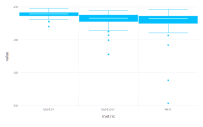

In [48]:
sims = 100
sim_results = [simulate_train_test_set(20, 4, m1) for _ in 1:sims] |>
    m -> hcat(m...)' |>
    m -> DataFrame(m, [:lppd_in, :lppd_out, :waic]) |>
    m -> stack(m, 1:3)

set_default_plot_size(8Gadfly.inch, 5Gadfly.inch)
rename!(sim_results, [:metric, :value])
plot(sim_results, x = :metric, y = :value, Geom.boxplot)

For model 2 with $N = 20$:

In [49]:
# sims = 1000
# sim_results = [simulate_train_test_set(20, 4, m2) for _ in 1:sims] |>
#     m -> hcat(m...)' |>
#     m -> DataFrame(m, [:lppd_in, :lppd_out, :waic]) |>
#     m -> stack(m, 1:3)

# gdf = groupby(sim_results, :variable)
# combine(:value => f, gdf)

For model 1 with $N = 200$:

In [50]:
# sims = 1000
# sim_results = [simulate_train_test_set(200, 4, m1) for _ in 1:sims] |>
#     m -> hcat(m...)' |>
#     m -> DataFrame(m, [:lppd_in, :lppd_out, :waic]) |>
#     m -> stack(m, 1:3)

# gdf = groupby(sim_results, :variable)
# combine(:value => f, gdf)

For model 2 With $N = 200$:

In [51]:
# sims = 1000
# sim_results = [simulate_train_test_set(200, 4, m2) for _ in 1:sims] |>
#     m -> hcat(m...)' |>
#     m -> DataFrame(m, [:lppd_in, :lppd_out, :waic]) |>
#     m -> stack(m, 1:3)

# gdf = groupby(sim_results, :variable)
# combine(:value => f, gdf)